In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

from torch.distributions.multivariate_normal import MultivariateNormal

import numpy as np 
import matplotlib.pyplot as plt  
%matplotlib inline

torch.manual_seed(1337)

## Hyperparameters & Data Loading

In [2]:
lr = 1e-3
gamma = 0.1
step_size = 10
num_epochs = 30
batch_size = 100

input_dim = 784
hidden_dim = 400
latent_dim = 20

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: torch.flatten(x)) # flattens to [784,]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

val_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

## VAE Model Architecture

In [4]:
class VAE(nn.Module):
    '''
    q_{\lambda}(z|x) ~ N(\mu, diag(\sigma^2))
    (\mu, log(\sigma)) = self.encoder(x) # encoder net params = \lambda
    '''
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            nn.ReLU()
        )
        
        self.mu = nn.Linear(in_features=hidden_dim, out_features=latent_dim)
        self.sigma = nn.Linear(in_features=hidden_dim, out_features=latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=input_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        mu, sigma = self.mu(x), self.sigma(x) 
        
        z = self.reparameterize(mu, sigma) 
        return self.decoder(z), mu, sigma 
    
    def reparameterize(self, mu, sigma):
        '''
        Reparameterization using factorized Gaussian posterior
        z = h(e, x, \lambda) where \lambda = Encoder NN's parameters
        '''
        e1 = torch.randn_like(sigma)
        e2 = torch.randn_like(sigma)
        return 0.5*((mu + sigma * e1) + (mu + sigma * e2))

## Sampling & Training Functions

In [5]:
def sample(model, epoch, num_samples, space=0.1, ncols=5):
    z = torch.randn((num_samples, latent_dim)).to(device)
    
    model.eval()
    with torch.no_grad():
        samples = model.decoder(z)
    
    nrows = int(num_samples / ncols)
    figsize = (15, 3*nrows)
    samples = samples.cpu().detach().numpy()
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharex=True, sharey=True, squeeze=True)   
    
    for ax, img in zip(axes.flatten(), samples):
        ax.imshow(img.reshape(28, 28), cmap='gray')
        ax.axis('off')
    
    plt.subplots_adjust(wspace=space, hspace=0)
    plt.suptitle(f'VAE Generated Samples after {epoch} Training epochs', y=1.005)
    plt.tight_layout(pad=0.5)
    plt.show()

In [6]:
def train(model, train_loader, val_loader, optimizer, scheduler, num_epochs):
    training_losses = []
    validation_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for i, batch in enumerate(train_loader):
            x, _ = batch
            x = x.to(device)
            
            optimizer.zero_grad()
            
            x_hat, mu, sigma = model(x) # [batch_size, input_dim], [batch_size, param_dim]
            reconstruction_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
            kl_divergence = -0.5 * torch.sum(1 + torch.log(sigma**2) - mu**2 - sigma**2)
            loss = reconstruction_loss + kl_divergence
            # print(f'R {reconstruction_loss:.4f} + KL {kl_divergence:.4f} = Loss {loss:.4f}')
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, _ in val_loader:
                x = x.to(device)
                x_hat, mu, sigma = model(x)
                reconstruction_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
                kl_divergence = -0.5 * torch.sum(1 + torch.log(sigma**2) - mu**2 - sigma**2)
                loss = reconstruction_loss + kl_divergence
                val_loss += loss.item()
        
        if epoch % 10 == 0:
            sample(model, epoch, num_samples=5)
            
        print(f"Epoch {epoch+1}, Training Loss: {(train_loss / len(train_loader)):.4f}, Validation Loss: {(val_loss / len(val_loader)):.4f}")
        training_losses.append((train_loss / len(train_loader))) # averaged over epochs
        validation_losses.append((val_loss / len(val_loader)))
        
        scheduler.step()
    
    return training_losses, validation_losses

## Training Results

In [7]:
model = VAE(input_dim, hidden_dim, latent_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

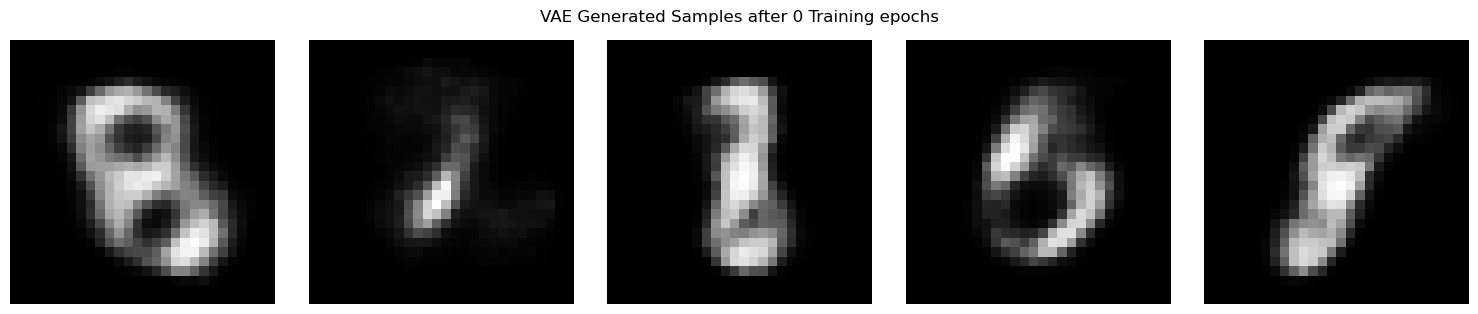

Epoch 1, Training Loss: 17067.9712, Validation Loss: 13074.2348
Epoch 2, Training Loss: 12268.9060, Validation Loss: 11548.1088
Epoch 3, Training Loss: 11279.7711, Validation Loss: 10907.8433
Epoch 4, Training Loss: 10782.1963, Validation Loss: 10502.1140
Epoch 5, Training Loss: 10471.3417, Validation Loss: 10303.7106
Epoch 6, Training Loss: 10267.9330, Validation Loss: 10160.0376
Epoch 7, Training Loss: 10122.9179, Validation Loss: 10007.3738
Epoch 8, Training Loss: 10008.5523, Validation Loss: 9899.3853
Epoch 9, Training Loss: 9934.7797, Validation Loss: 9865.8430
Epoch 10, Training Loss: 9854.8673, Validation Loss: 9807.5804


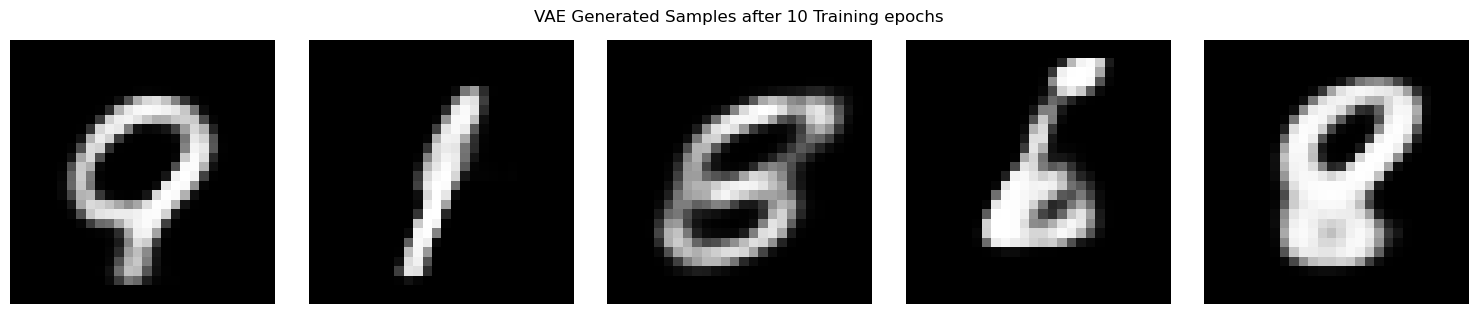

Epoch 11, Training Loss: 9590.8055, Validation Loss: 9572.4758
Epoch 12, Training Loss: 9544.9334, Validation Loss: 9554.0756
Epoch 13, Training Loss: 9531.4372, Validation Loss: 9539.2892
Epoch 14, Training Loss: 9517.4794, Validation Loss: 9530.9357
Epoch 15, Training Loss: 9503.8901, Validation Loss: 9530.5944
Epoch 16, Training Loss: 9493.7584, Validation Loss: 9518.1493
Epoch 17, Training Loss: 9483.0674, Validation Loss: 9508.3469
Epoch 18, Training Loss: 9474.9251, Validation Loss: 9503.3587
Epoch 19, Training Loss: 9465.8658, Validation Loss: 9485.8717
Epoch 20, Training Loss: 9459.2032, Validation Loss: 9486.7833


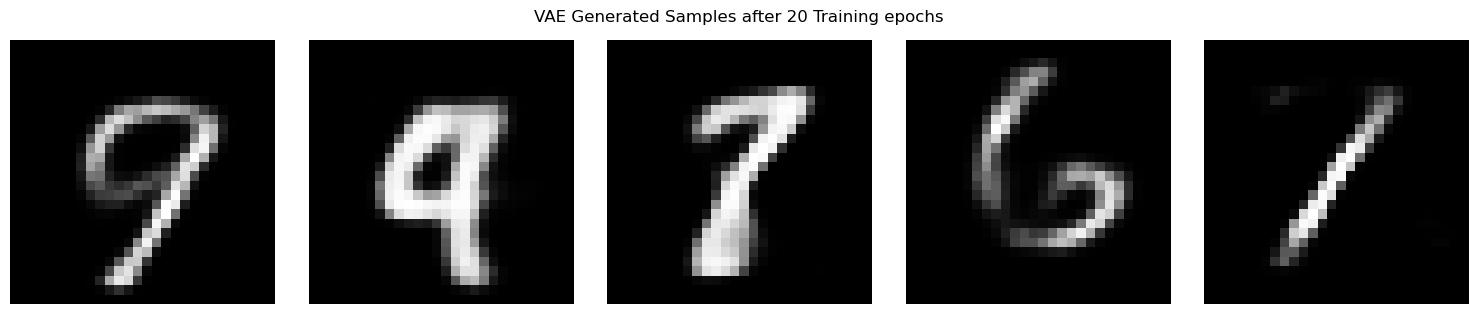

Epoch 21, Training Loss: 9430.2559, Validation Loss: 9469.8705
Epoch 22, Training Loss: 9423.0141, Validation Loss: 9467.4791
Epoch 23, Training Loss: 9419.4046, Validation Loss: 9457.4047
Epoch 24, Training Loss: 9416.7986, Validation Loss: 9463.2985
Epoch 25, Training Loss: 9419.1609, Validation Loss: 9464.5046
Epoch 26, Training Loss: 9416.3229, Validation Loss: 9461.3981
Epoch 27, Training Loss: 9415.2966, Validation Loss: 9460.7448
Epoch 28, Training Loss: 9413.5991, Validation Loss: 9452.3641
Epoch 29, Training Loss: 9410.6985, Validation Loss: 9451.6791
Epoch 30, Training Loss: 9412.7533, Validation Loss: 9456.9637


In [8]:
training_losses, validation_losses = train(model, train_loader, val_loader, optimizer, scheduler, num_epochs)

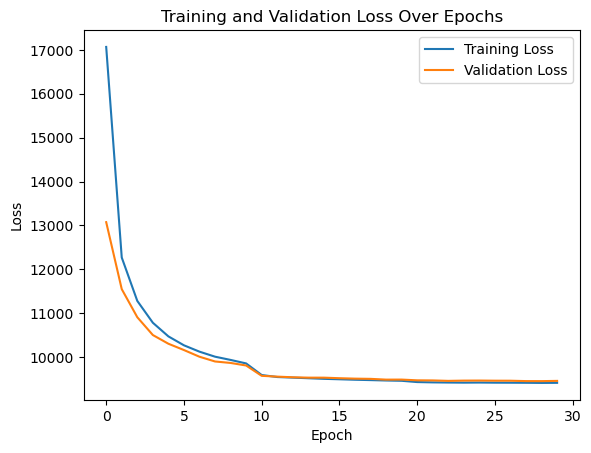

In [9]:
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

## Final VAE Samples

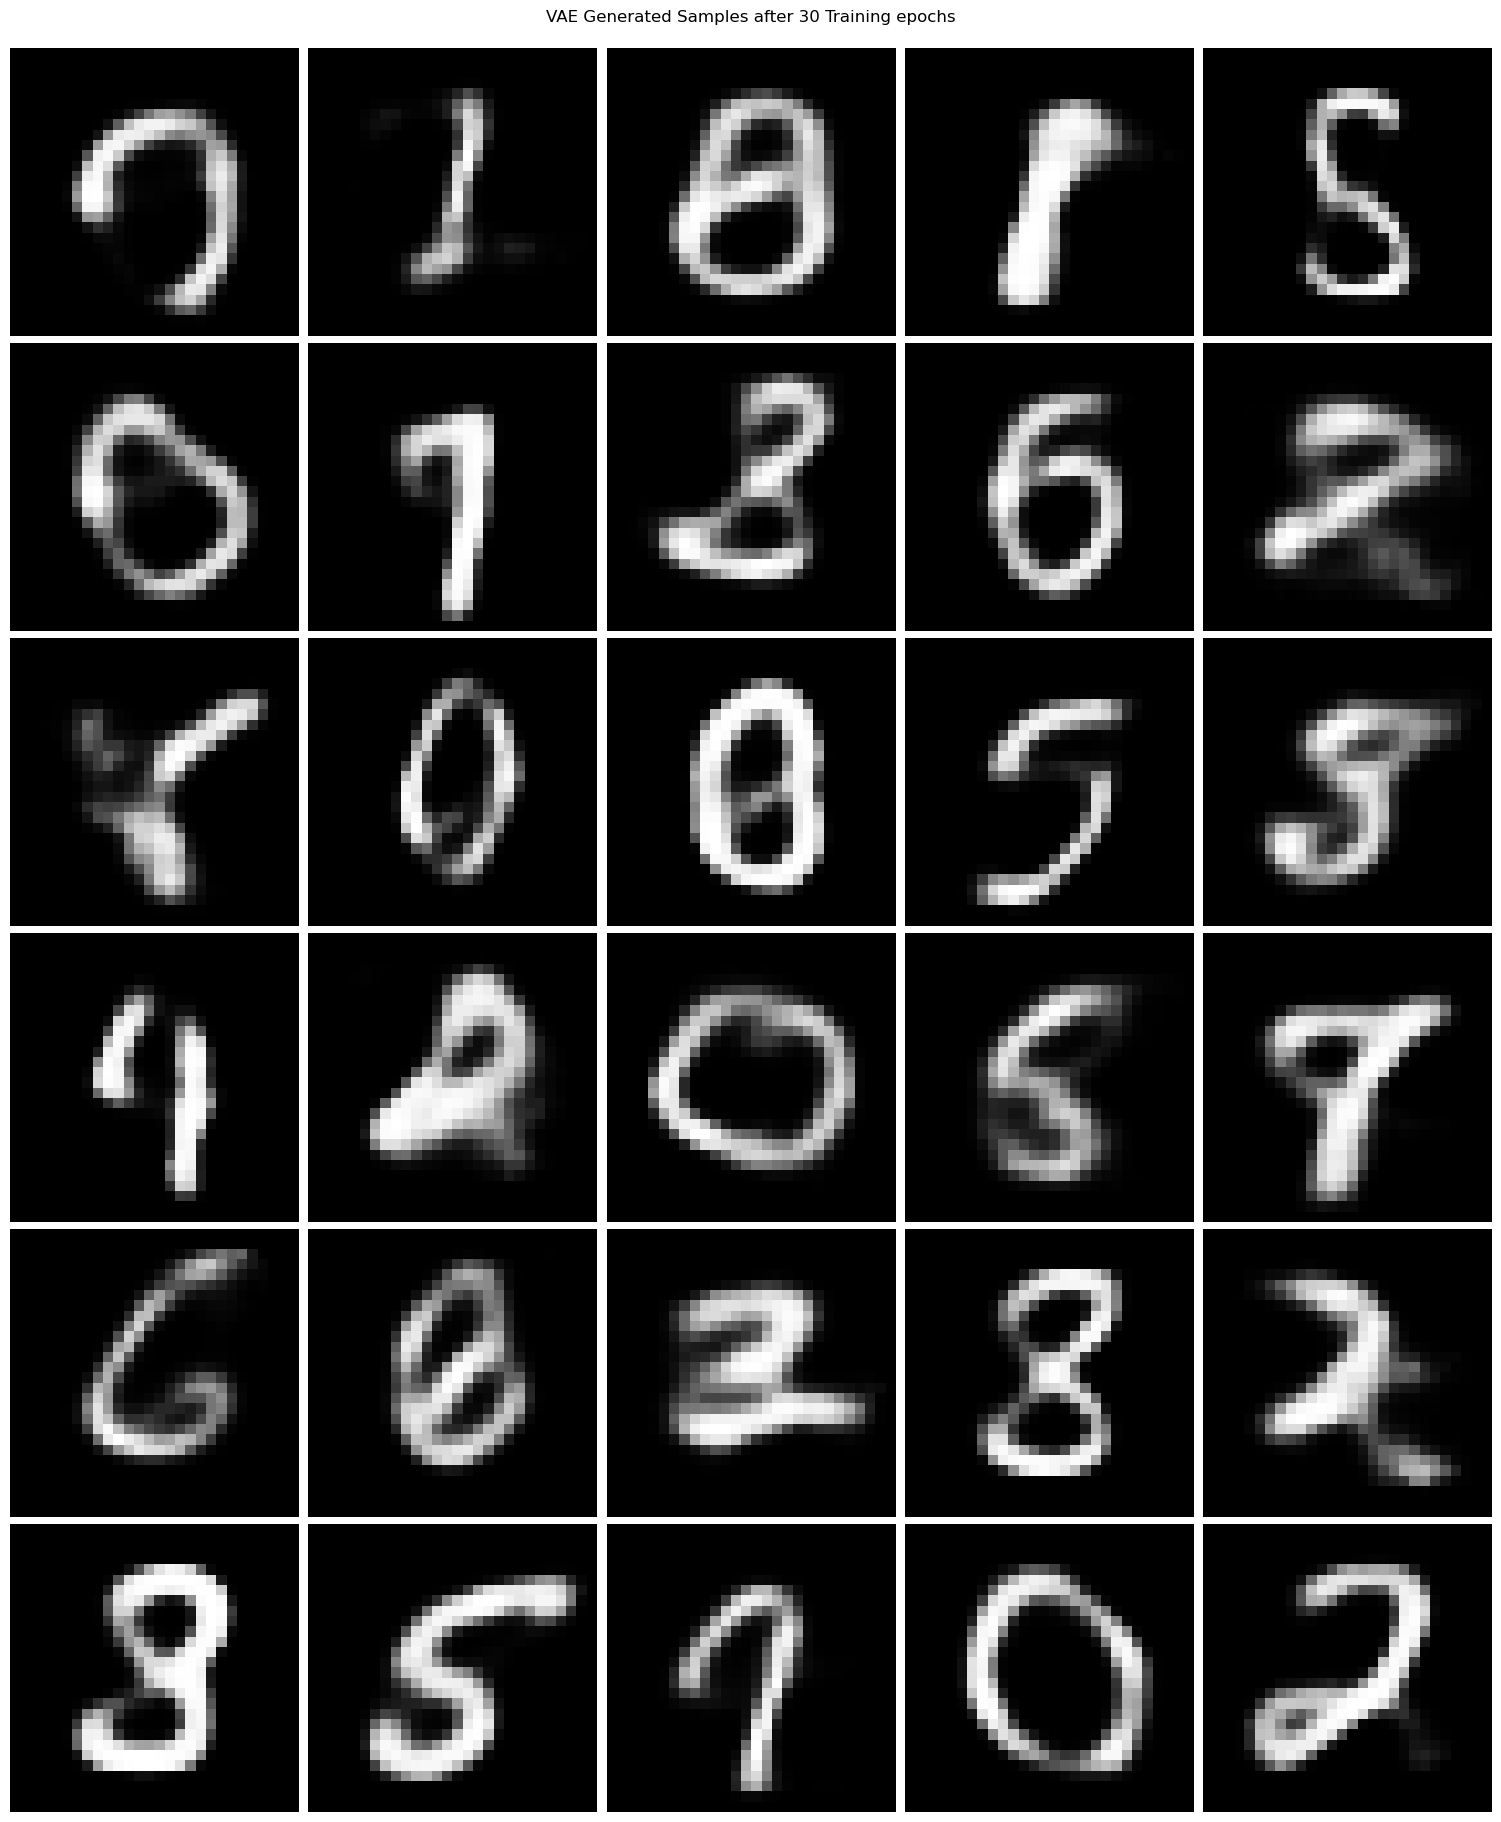

In [10]:
sample(model, num_epochs, num_samples=30, space=0)